In [1]:
import pandas3js as pjs
print('pandasjs version = {}'.format(pjs.__version__))
import jsonextended as ejson
print('jsonextended version = {}'.format(ejson.__version__))
import pandas as pd
import numpy as np
import pythreejs as tjs
import traitlets as trait
import ipywidgets as widget
import matplotlib.pyplot as plt
%matplotlib inline
import bqplot as bq

pandasjs version = 0.1.5.1
jsonextended version = 0.1.4


# JSON extended with folder

In [2]:
data = ejson.json_to_dict(ejson.get_test_path())
ejson.dict_pprint(data, depth=3)

dir1: 
  dir1_1: 
    file1_1: {...}
  file1: 
    initial: {...}
    meta: {...}
    optimised: {...}
    units: {...}
  file2: 
    initial: {...}
    meta: {...}
    optimisation: {...}
    optimised: {...}
    units: {...}
dir2: 
  file1: 
    initial: {...}
    meta: {...}
    optimisation: {...}
    optimised: {...}
    units: {...}
dir3: 


In [3]:
data = ejson.dict_remove_paths(data, ['units'])
energies = ejson.dict_filter_keys(data, ['energy'])
pd.Series(ejson.dict_flatten(energies)).describe()

count       89.000000
mean    -24062.286741
std          0.012361
min     -24062.293964
25%     -24062.293727
50%     -24062.293491
75%     -24062.278072
max     -24062.207939
dtype: float64

In [4]:
energies = ejson.units.apply_unitschema(energies, {'energy':'eV'})
energies = ejson.units.apply_unitschema(energies, {'energy':'kcal'},as_quantity=False)
pd.Series(ejson.dict_flatten(energies)).describe()

count    8.900000e+01
mean    -9.214157e-19
std      4.733481e-25
min     -9.214159e-19
25%     -9.214159e-19
50%     -9.214159e-19
75%     -9.214153e-19
max     -9.214126e-19
dtype: float64

In [5]:
data = ejson.json_to_dict(ejson.get_test_path())
optimisation = ejson.dict_multiindex(data,['dir1','file2','optimisation','steps'])
optsteps = sorted(optimisation.keys(), key=ejson.core._natural_keys)
print(optsteps)

[u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'23', u'24', u'25', u'26', u'27', u'28', u'29', u'30', u'31', u'32', u'33', u'34', u'35', u'36', u'37', u'38', u'39', u'40', u'41', u'42', u'43', u'44', u'45', u'46', u'47', u'48', u'49', u'50', u'51', u'52', u'53', u'54', u'55', u'56', u'57', u'58', u'59', u'60', u'61', u'62', u'63', u'64', u'65', u'66', u'67', u'68', u'69', u'70', u'71', u'72', u'73', u'74', u'75', u'76', u'77', u'78', u'79', u'80', u'81', u'82', u'83', u'84', u'85', u'86', u'87', u'88', u'89', u'90']


In [6]:
ejson.dict_pprint(optimisation['2'],
                  depth=None,no_values=True)

crystallographic: 
  geometry: 
    assym:         
    atomic_number: 
    id:            
    label:         
    x/a:           
    y/b:           
    z/c:           
  lattice_parameters: 
    a:     
    alpha: 
    b:     
    beta:  
    c:     
    gamma: 
  volume: 
energy: 
primitive: 
  density: 
  geometry: 
    assym:         
    atomic_number: 
    id:            
    label:         
    x/a:           
    y/b:           
    z/c:           
  lattice_parameters: 
    a:     
    alpha: 
    b:     
    beta:  
    c:     
    gamma: 
  volume:  


In [7]:
ejson.dict_to_html(optimisation['2'])

# Empty GUI

In [35]:
gui, geometry = pjs.views.create_gui()
gui

In [36]:
geometry.add_object(pjs.models.Sphere(id=1,color='blue',label='S'))
geometry.add_object(pjs.models.Box(id=2,position=[1,1,1],
                                   color='green',label='B'))
geometry

,color,depth,height,id,label,label_color,label_transparency,label_visible,other_info,otype,position,radius,transparency,visible,width
0,blue,NaN,NaN,1,S,red,1.0,False,,pandas3js.models.idobject.Sphere,"(0.0, 0.0, 0.0)",1.0,1.0,True,NaN
1,green,1.0,1.0,2,B,red,1.0,False,,pandas3js.models.idobject.Box,"(1.0, 1.0, 1.0)",NaN,1.0,True,1.0


# Simple GUI Options and Callback

In [2]:
def callback(geometry, options):
    for obj in geometry:
        obj.label = options['label']
        obj.color = options['color']
        obj.transparency = options['opaque']
    return
  
geometry = pjs.models.GeometricCollection()
geometry.add_object(pjs.models.Sphere(id=1,label='S'))
geometry.add_object(pjs.models.Box(id=2,position=[2,1,1],
                                   label='B'))

gui, geometry = pjs.views.create_gui(geometry, callback,
                                     opts_choice={'label':['A','B']},
                                     opts_color={'color':'blue'},
                                     opts_range={'opaque':np.arange(1.0, 0.1, -0.1)})
gui

# Crystal Example

In [157]:
datapath = ejson.utils.get_data_path('crystal_test.data',ejson.parsers)
with open(datapath) as f:
    for i in range(10):
        print(f.readline().strip())

date:               Thu Aug 18 20:03:15 BST 2016
hostname:           cx1-12-5-3.cx1.hpc.ic.ac.uk
system:             Linux cx1-12-5-3.cx1.hpc.ic.ac.uk 2.6.32-573.12.1.el6.x86_64 #1 SMP Tue Dec 15 06:42:08 PST 2015 x86_64 x86_64 x86_64 GNU/Linux
user:               ea808
input:              /export111/work/ea808/crystal/corrosion/fes_phases/ehsan/pyrrhotite_B3LYP_AFM_SL12_fullOPT.d12
output:             /export111/work/ea808/crystal/corrosion/fes_phases/ehsan/pyrrhotite_B3LYP_AFM_SL12_fullOPT.out
executable script:  /home/gmallia/CRYSTAL14_cx1/runcry14P
executable dir:     /home/ea808/../gmallia/CRYSTAL14_cx1/trunk406_v1.0/bin/Linux-mpiifort/Xeon___mpi__intel-3.1___intel-suite__2013
executables:
-rwxr-xr-x 1 gmallia hpc-users    23486 May 21  2014 INFO


In [2]:
parser = ejson.parsers.CrystalDFTParser()
parser.read_file(datapath)
ejson.dict_pprint(parser.data,depth=1)
print('----')
ejson.dict_pprint(parser.data,depth=2)

initial: {...}
meta: {...}
optimisation: {...}
optimised: {...}
scf: {...}
----
initial: 
  crystallographic: {...}
  primitive: {...}
meta: 
  converged:  True
  input file: /export111/work/ea808/crystal/corrosion/fes_phases/ehsan/pyrrhotit 
              e_B3LYP_AFM_SL12_fullOPT.d12
  processors: 96
  start date: Thu Aug 18 20:03:15 BST 2016
optimisation: 
  steps: {...}
optimised: 
  crystallographic: {...}
  energy: -24062.2939637
  primitive: {...}
scf: 
  calculation type: UNRESTRICTED OPEN SHELL
  step:             {...}


In [21]:
volumes = ejson.dict_filter_paths(parser.data, [('primitive','volume')])
ejson.dict_pprint(volumes,depth=None)

initial: 
  primitive: 
    volume: 462.313764
optimisation: 
  steps: 
    2: 
      primitive: 
        volume: 479.747725
    3: 
      primitive: 
        volume: 507.338796
    4: 
      primitive: 
        volume: 523.871153
    5: 
      primitive: 
        volume: 528.039438
    6: 
      primitive: 
        volume: 530.306031
    7: 
      primitive: 
        volume: 526.738665
    8: 
      primitive: 
        volume: 522.256155
    9: 
      primitive: 
        volume: 520.554523
    10: 
      primitive: 
        volume: 520.599072
    11: 
      primitive: 
        volume: 521.640237
    12: 
      primitive: 
        volume: 522.665697
    13: 
      primitive: 
        volume: 523.098131
    14: 
      primitive: 
        volume: 523.045772
    15: 
      primitive: 
        volume: 522.692263
    16: 
      primitive: 
        volume: 522.416826
    17: 
      primitive: 
        volume: 522.287563
    18: 
      primitive: 
        volume: 522.314355
    19: 
      pri

In [23]:
volumes = ejson.units.apply_unitschema(volumes,{'volume':'angstrom^3'})
volumes = ejson.units.apply_unitschema(volumes,{'volume':'nm^3'})
ejson.dict_pprint(volumes,depth=None)

initial: 
  primitive: 
    volume: 0.000462313764 nm ** 3
optimisation: 
  steps: 
    2: 
      primitive: 
        volume: 0.000479747725 nm ** 3
    3: 
      primitive: 
        volume: 0.000507338796 nm ** 3
    4: 
      primitive: 
        volume: 0.000523871153 nm ** 3
    5: 
      primitive: 
        volume: 0.000528039438 nm ** 3
    6: 
      primitive: 
        volume: 0.000530306031 nm ** 3
    7: 
      primitive: 
        volume: 0.000526738665 nm ** 3
    8: 
      primitive: 
        volume: 0.000522256155 nm ** 3
    9: 
      primitive: 
        volume: 0.000520554523 nm ** 3
    10: 
      primitive: 
        volume: 0.000520599072 nm ** 3
    11: 
      primitive: 
        volume: 0.000521640237 nm ** 3
    12: 
      primitive: 
        volume: 0.000522665697 nm ** 3
    13: 
      primitive: 
        volume: 0.000523098131 nm ** 3
    14: 
      primitive: 
        volume: 0.000523045772 nm ** 3
    15: 
      primitive: 
        volume: 0.000522692263 nm ** 3


In [66]:
volumes = ejson.dict_filter_paths(parser.data, [('optimisation','primitive','volume'),
                                                ('optimisation','step')])
volumes = ejson.dict_remove_keys(volumes,['primitive'])
volumes = pd.DataFrame(ejson.dict_flatten2d(volumes)).T
volumes.head()

step      volume
optimisation steps 10  10.0  520.599072
                   11  11.0  521.640237
                   12  12.0  522.665697
                   13  13.0  523.098131
                   14  14.0  523.045772

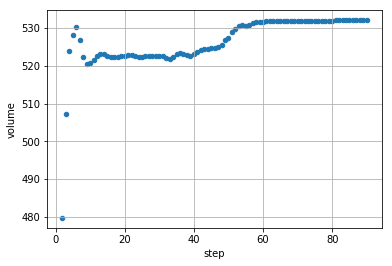

In [70]:
volumes.plot.scatter('step','volume',grid=True);

## Initial Geometry

In [3]:
ejson.dict_pprint(parser.data['initial']['primitive'],depth=2)

density: 4.65
geometry: 
  assym:         [True, False, False, False, True, False, False, False, True, 
                 False, False, False, True, False, False, False, True, False, 
                 False, False, True, False, False, False, True, False, False, 
                 False, True, False]
  atomic_number: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                 16, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
  id:            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
                 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  label:         [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, FE, FE, FE, 
                 FE, FE, FE, FE, FE, FE, FE, FE, FE, FE, FE]
  x:             [-3.457389260668, 0.4233303275066, 3.457389260668, 
                 -0.4233303275066, 0.5505878964006, -3.449328963239, 
                 -0.5505878964006, 3.449328963239, -0.4582129497425, 
                 -2.575845983419, 0.4582129497425

In [17]:
data = ejson.dict_combine_lists(parser.data,['id','x/a','y/b','z/c','atomic_number'],'ixyzn')
ejson.dict_pprint(data['initial']['primitive']['geometry']['ixyzn'])

1: 
  atomic_number: 16
  id:            1
  x/a:           -0.22
  y/b:           -0.03
  z/c:           0.384
2: 
  atomic_number: 16
  id:            2
  x/a:           -0.03
  y/b:           -0.22
  z/c:           0.116
3: 
  atomic_number: 16
  id:            3
  x/a:           0.22
  y/b:           0.03
  z/c:           -0.384
4: 
  atomic_number: 16
  id:            4
  x/a:           0.03
  y/b:           0.22
  z/c:           -0.116
5: 
  atomic_number: 16
  id:            5
  x/a:           0.223
  y/b:           -0.475
  z/c:           -0.386
6: 
  atomic_number: 16
  id:            6
  x/a:           -0.475
  y/b:           0.223
  z/c:           -0.114
7: 
  atomic_number: 16
  id:            7
  x/a:           -0.223
  y/b:           0.475
  z/c:           0.386
8: 
  atomic_number: 16
  id:            8
  x/a:           0.475
  y/b:           -0.223
  z/c:           0.114
9: 
  atomic_number: 16
  id:            9
  x/a:           0.272
  y/b:           -0.02
  z/c:     

In [17]:
df = pd.DataFrame({'a':[1]},index=[1])
1 in df.index

True

In [158]:
import urllib #urllib2 for python3
f = urllib.urlopen(
    'https://raw.githubusercontent.com/chrisjsewell'
    '/jsonextended/master/jsonextended/parsers/crystal_test.data')
parser = ejson.parsers.CrystalDFTParser()
parser.read_file(f)
f.close()

data = ejson.dict_combine_lists(parser.data,['id','x/a','y/b','z/c','atomic_number','assym'],'ixyzn')
geometry = pjs.models.GeometricCollection()

# create bounding box
ldict = data['initial']['primitive']['lattice_parameters']
a_vec, b_vec, c_vec = pjs.atom.lattice_from_params(
     *[ldict[s] for s in ('a','b','c','alpha','beta','gamma')])
bbox = pjs.models.TriclinicWire(id=-1,a=a_vec,b=b_vec,c=c_vec,color='black')  
bbox.other_info = True
geometry.add_object(bbox)

# create atoms
for d in data['initial']['primitive']['geometry']['ixyzn'].values():
    x,y,z = d['x/a']*a_vec+d['y/b']*b_vec+d['z/c']*c_vec
    atom = pjs.models.Sphere(id=d['id'],position=(x,y,z))
    atom.color = atom.label_color = pjs.atom.map_atoms(d['atomic_number'],'color')
    atom.radius = pjs.atom.map_atoms(d['atomic_number'],'RCov')
    atom.label = pjs.atom.map_atoms(d['atomic_number'],'Symbol')
    atom.other_info = d['assym']
    geometry.add_object(atom)    

# repeat unit cell
pjs.atom.repeat_cell(geometry,a_vec)
pjs.atom.repeat_cell(geometry,b_vec)

def callback(geometry, options):
    for obj in geometry:
        if options['Show Assymetric Unit'] and obj.other_info=='False':
            obj.visible = False
        elif options['Hide Fe'] and obj.label == 'Fe':
            obj.visible = False
        else:
            obj.visible = True

gui, geometry = pjs.views.create_gui(geometry,callback,
                                     opts_choice={'Hide Fe':[False,True],
                                                 'Show Assymetric Unit':[False,True]},
                                     orthographic=True,add_labels=True)
gui

In [79]:
gui.children[0].children[1]

## SCF

In [5]:
ejson.dict_pprint(parser.data['scf']['step'][100],depth=2)

FDIK:                 
  TCPU:    4300.24
  TELAPSE: 4305.28
MONMO3:               
  TCPU:    4277.06
  TELAPSE: 4282.07
NUMDFT:               
  TCPU:    4281.72
  TELAPSE: 4286.74
PDIG:                 
  TCPU:    4303.43
  TELAPSE: 4308.47
SHELLX2:              
  TCPU:    4268.81
  TELAPSE: 4273.82
charge:               [17.0968937, 17.0968937, 17.0968937, 17.0968937, 
                      17.1086638, 17.1086638, 17.1086638, 17.1086638, 
                      17.0725986, 17.0725986, 17.0725986, 17.0725986, 
                      17.2583021, 17.2583021, 17.2583021, 17.2583021, 24.642102, 
                      24.642102, 24.642102, 24.642102, 24.7306488, 24.7306488, 
                      24.7306488, 24.7306488, 24.7043459, 24.7043459, 
                      24.7043459, 24.7043459, 24.7728903, 24.7728903]
charge normalisation: 1.0
energy:               -24062.1598272
spin:                 [0.1949882, 0.1949882, 0.1949882, 0.1949882, 0.190179, 
                      0.190179, 0.190

In [160]:
import urllib #urllib2 for python3
# f = urllib.urlopen(
#     'https://raw.githubusercontent.com/chrisjsewell'
#     '/jsonextended/master/jsonextended/parsers/crystal_test.data')
datapath = ejson.utils.get_data_path('crystal_test.data',ejson.parsers)
parser = ejson.parsers.CrystalDFTParser()
parser.read_file(datapath)
f.close()

data = ejson.dict_combine_lists(parser.data,
            ['id','x/a','y/b','z/c','atomic_number','assym'],'ixyzn')
geometry = pjs.models.GeometricCollection()

# create bounding box
ldict = data['initial']['primitive']['lattice_parameters']
a_vec, b_vec, c_vec = pjs.atom.lattice_from_params(
     *[ldict[s] for s in ('a','b','c','alpha','beta','gamma')])
bbox = pjs.models.TriclinicWire(id=-1,a=a_vec,b=b_vec,c=c_vec,color='black')  
bbox.other_info = True
geometry.add_object(bbox)

# create atoms
for d in data['initial']['primitive']['geometry']['ixyzn'].values():
    x,y,z = d['x/a']*a_vec+d['y/b']*b_vec+d['z/c']*c_vec
    atom = pjs.models.Sphere(id=d['id'],position=(x,y,z))
    atom.color = atom.label_color = pjs.atom.map_atoms(d['atomic_number'],'color')
    atom.radius = pjs.atom.map_atoms(d['atomic_number'],'RCov')
    atom.label = pjs.atom.map_atoms(d['atomic_number'],'Symbol')
    atom.other_info = d['assym']
    geometry.add_object(atom)    

# repeat unit cell
pjs.atom.repeat_cell(geometry,a_vec)
pjs.atom.repeat_cell(geometry,b_vec)

scfdata = parser.data['scf']['step']
def callback(geometry, options):
    charges = scfdata[options['SCF Step']]['charge']
    spins = scfdata[options['SCF Step']]['spin']
    ccolor = pjs.atom.color_by_value(charges,10.,30.)
    scolor = pjs.atom.color_by_value(spins,-5.,5.)

    for obj in geometry:
        if not obj.has_trait('radius'):
            continue
        if options['Show Assymetric Unit'] and obj.other_info=='False':
            obj.visible = False
        elif options['Hide S'] and obj.label == 'S':
            obj.visible = False
        elif options['Hide Fe'] and obj.label == 'Fe':
            obj.visible = False
        else:
            obj.visible = True
        id = obj.id[0] if isinstance(obj.id, tuple) else obj.id
        if options['Color By'] == 'type':
            obj.color = pjs.atom.map_atoms(obj.label,'color','Symbol')  
        elif options['Color By'] == 'charge':
            obj.color = ccolor[id-1]
        elif options['Color By'] == 'spin':
            obj.color = scolor[id-1]
        else:
            obj.color = 'black'
    return  

gui, geometry = pjs.views.create_gui(geometry,callback,
                                     opts_choice={'Hide Fe':[False,True],
                                                  'Hide S':[False,True],
                                                 'Show Assymetric Unit':[False,True],
                                                 'Color By':['type','charge','spin']},
                                     opts_range={'SCF Step':pjs.utils.natural_sort(scfdata)},
                                     orthographic=True,add_labels=True)
gui

## Optimisation

In [33]:
ejson.dict_pprint(parser.data['optimisation']['steps']['2']['primitive'],depth=3)

density: 4.481
geometry: 
  assym:         [True, False, False, False, True, False, False, False, True, 
                 False, False, False, True, False, False, False, True, False, 
                 False, False, True, False, False, False, True, False, False, 
                 False, True, False]
  atomic_number: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                 16, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
  id:            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
                 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  label:         [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, FE, FE, FE, 
                 FE, FE1, FE1, FE1, FE1, FE, FE, FE, FE, FE1, FE1]
  x/a:           [-0.2210124308332, -0.0286759547147, 0.2210124308332, 
                 0.0286759547147, 0.2244361247749, -0.4738415381816, 
                 -0.2244361247749, 0.4738415381816, 0.2723358734368, 
                 -0.01972869479072, -0.

In [202]:
import contextlib
class Change(object):
    new = None

class link_func(object):
    """Link traits from different objects together so they remain in sync.
    Parameters
    ----------
    source : (object / attribute name / function)
    target : (object / attribute name / function)
    Examples
    --------
    >>> c = link((src, 'value'), (tgt, 'value'))
    >>> src.value = 5  # updates other objects as well
    """
    updating = False

    def __init__(self, source, target):
        #_validate_link(source, target)
        self.source, self.target = source, target
        self.link()

    def link(self):
        try:
            change = Change()
            change.new = getattr(self.source[0], self.source[1])
            self.source[2](change)
        finally:
            self.source[0].observe(self._update_target, names=self.source[1])
            self.target[0].observe(self._update_source, names=self.target[1])

    @contextlib.contextmanager
    def _busy_updating(self):
        self.updating = True
        try:
            yield
        finally:
            self.updating = False

    def _update_target(self, change):
        if self.updating:
            return
        with self._busy_updating():
            self.source[2](change)

    def _update_source(self, change):
        if self.updating:
            return
        with self._busy_updating():
            self.target[2](change)

    def unlink(self):
        self.source[0].unobserve(self._update_target, names=self.source[1])
        self.target[0].unobserve(self._update_source, names=self.target[1])


In [221]:
import urllib #urllib2 for python3
f = urllib.urlopen(
    'https://raw.githubusercontent.com/chrisjsewell'
    '/jsonextended/master/jsonextended/parsers/crystal_test.data')
parser = ejson.parsers.CrystalDFTParser()
parser.read_file(f)
f.close()
data = parser.data['optimisation']['steps']

def change_config(geometry, options):
    
    cdata = ejson.dict_multiindex(data,
                [options['Configuration'],
                'primitive'])

    # compute lattice vectors
    ldict = cdata['lattice_parameters']
    a_vec, b_vec, c_vec = pjs.atom.lattice_from_params(
         *[ldict[s] for s in ('a','b','c','alpha','beta','gamma')])
    
    gdict = cdata['geometry']
    df = pd.DataFrame(gdict)
        
    df['position']  = [tuple(xa*a_vec+yb*b_vec+zc*c_vec) 
                       for xa,yb,zc in df[['x/a','y/b','z/c']].values]

    # label/color atom by atomic number
    df.label = pjs.atom.map_atoms(df['atomic_number'].values,'Symbol')
    df['color'] = pjs.atom.map_atoms(df['atomic_number'].values,'color')
    df['label_color'] = df['color']
    df['radius'] = pjs.atom.map_atoms(df['atomic_number'].values,'RCov')
    
    df = df[['id','position','label','label_color',
             'color','radius']]
    df['otype'] = 'pandas3js.models.Sphere'
    
    if options.get('Show Cell Box',False):
        series = pd.Series({'a':tuple(a_vec),'b':tuple(b_vec),'c':tuple(c_vec),
                            'otype':'pandas3js.models.TriclinicWire',
                            'id':'box','color':'black','position':(0,0,0)})    
        df = df.append(series,ignore_index=True,)
    
#    df = pjs.atom.repeat_cell_df(df,a_vec)
#    df = pjs.atom.repeat_cell_df(df,b_vec)

    # bonds between sub-lattice atoms
    if options.get('Show Coordination', False):
        for aname, anumber in (['S',16],):#,['Fe',26]):
            color = pjs.atom.map_atoms([anumber],'color')[0]
            
            bond_pairs = pjs.atom.find_bonds(df[df.label==aname]['position'].tolist())
            bond_ids = pjs.atom.find_bonds(df[df.label==aname]['position'].tolist(),
                                          index=df[df.label==aname]['id'].tolist())
            for (id1,id2),(i,j) in zip(bond_ids, bond_pairs):
                series = pd.Series({
                    'position':i,'end':j,
                    'color':color,'end_color':color,
                    'otype':'pandas3js.models.Line',
                    'id':('bond',id1,id2),'linewidth':3})
                df = df.append(series,ignore_index=True,)
    
    geometry.change_by_df(df,otype_column='otype',
                          remove_missing=True)        
    return

gui, geometry = pjs.views.create_gui(callback=change_config,orthographic=True,
                                  add_labels=False,view=(10, -10, -10, 10),
                                  otype_column='otype',camera_position=[0,0,10],
                                  opts_range = {'Configuration':
                                                pjs.utils.natural_sort(data.keys())},
                                  opts_choice={'Show Coordination':[False, True],
                                           'Show Cell Box':[True,False]},
                                  main_controls=['Configuration'])

config_slider = gui.children[0].children[0].children[1]

df = pd.DataFrame(
    ejson.dict_remove_keys(
    ejson.dict_filter_paths(
        parser.data['optimisation']['steps'],
        [('step',),('primitive','density'),('primitive','volume')]),
        ['primitive'])).T.set_index('step').sort_index()

x_scale = bq.LinearScale()
y_scale = bq.LinearScale()

x_ax = bq.Axis(label='Configuration', scale=x_scale)
y_variable = 'volume'
y_ax = bq.Axis(label=y_variable.capitalize(), scale=y_scale, orientation='vertical')
line = bq.Lines(x=df.index.astype(int), y=df[y_variable].values, 
                scales={'x': x_scale, 'y': y_scale}, colors=['orange'],
               display_legend=True, labels=[y_variable])
line.selected = [df.index.astype(int)[0]-1]
y_scale2 = bq.LinearScale()
y_variable2 = 'density'
y_ax2 = bq.Axis(label=y_variable2.capitalize(), scale=y_scale2, 
                orientation='vertical',side='right')
line2 = bq.Lines(x=df.index.astype(int), y=df[y_variable2].values, 
                scales={'x': x_scale, 'y': y_scale2}, colors=['blue'],
                display_legend=True, labels=[y_variable2])

iselector = bq.interacts.IndexSelector(scale=x_scale, marks=[line,line2])

# import time
# now = time.time()
# def line_callback(change):
#     global now
#     if time.time() - now >= 1:
#         config_slider.value = str(change.new[0])
#         now = time.time()
    
# line.observe(line_callback, names=['selected'])
# iselector.selected = [int(config_slider.value)]
# def slider_callback(change):
#     global now
#     if time.time() - now >= 1:
#         iselector.selected = [int(change.new)]
#         now = time.time()
# config_slider.observe(slider_callback, names=['value'],)

import time
def slider_callback(change):
    iselector.selected = [int(config_slider.value)]
def line_callback(change):
    new = change.new
    # hold up while selector is moving
    time.sleep(.5)
    if new == line.selected:
        config_slider.value = str(new[0]+1)
link_func((line,'selected',line_callback),
          (config_slider,'value',slider_callback))

fig = bq.Figure(marks=[line,line2], axes=[x_ax, y_ax,y_ax2], #title='Title',
                         interaction=iselector,
                layout={'width':'400px','height':'300px'})
widget.HBox([gui,fig])

In [79]:
gui.close()

# Quaternion Rotation

In [80]:
render.camera.position = [0.15112475372064813, 0.41804944513679193, .9]

In [59]:
render = gui.children[1]
alpha = np.radians(50)
print(render.camera.quaternion)
render.camera.quaternion_from_rotation([ 
                np.cos(alpha), -np.sin(alpha), 0, 
                np.sin(alpha), np.cos(alpha),  0, 
                0,             0,              1
            ])
print(render.camera.quaternion)


[0.04293297400510096, 0.41105752390311934, -0.01938498105751881, 0.9103915029200877]
[0.0, 0.0, -0.4226182617406994, 0.90630778703665]


# Implementation of Spherical Harmonics

In [ ]:
np.polynomial.legendre.Legendre()

In [ ]:
# from scipy.special

cimport sf_error

cdef extern from "specfun_wrappers.h":
    double pmv_wrap(double, double, double) nogil

cdef extern from "c_misc/misc.h":
    double poch(double x, double m) nogil

from _complexstuff cimport *
from libc.math cimport cos, sqrt, fabs
from libc.stdlib cimport abs

cdef inline double complex sph_harmonic(int m, int n, double theta, double phi) nogil:
    cdef double x, prefactor
    cdef double complex val
    cdef int mp
    x = cos(phi)
    if abs(m) > n :
        sf_error.error("sph_harm", sf_error.ARG, "m should not be greater than n")
        return nan
    if n < 0:
        sf_error.error("sph_harm", sf_error.ARG, "n should not be negative")
        return nan
    if m < 0:
        mp = -m
        prefactor = (-1)**mp * poch(n + mp + 1, -2 * mp)
    else:
        mp = m
    val = pmv_wrap(mp, n, x)
    if  m < 0:
        val *= prefactor
    val *= sqrt((2*n + 1) / 4.0 / pi)
    val *= sqrt(poch(n + m + 1, -2 * m))
    val *= zexp(1j * m * theta)
return val

poch         -- The Pochhammer symbol (rising factorial).
/*
* Pochhammer symbol (a)_m = gamma(a + m) / gamma(a)
*/

#include <Python.h>
#include <numpy/npy_math.h>

#include <math.h>
#include "cephes.h"
#include "misc.h"

static double is_nonpos_int(double x)
{
   return x <= 0 && x == ceil(x) && fabs(x) < 1e13;
}

double poch(double a, double m)
{
   double r;

   r = 1.0;

   /*
    * 1. Reduce magnitude of `m` to |m| < 1 by using recurrence relations.
    *
    * This may end up in over/underflow, but then the function itself either
    * diverges or goes to zero. In case the remainder goes to the opposite
    * direction, we end up returning 0*INF = NAN, which is OK.
    */

   /* Recurse down */
   while (m >= 1.0) {
       if (a + m == 1) {
           break;
       }
       m -= 1.0;
       r *= (a + m);
       if (!npy_isfinite(r) || r == 0) {
           break;
       }
   }

   /* Recurse up */
   while (m <= -1.0) {
       if (a + m == 0) {
           break;
       }
       r /= (a + m);
       m += 1.0;
       if (!npy_isfinite(r) || r == 0) {
           break;
       }
   }

   /*
    * 2. Evaluate function with reduced `m`
    *
    * Now either `m` is not big, or the `r` product has over/underflown.
    * If so, the function itself does similarly.
    */

   if (m == 0) {
       /* Easy case */
       return r;
   }
   else if (a > 1e4 && fabs(m) <= 1) {
       /* Avoid loss of precision */
       return r * pow(a, m) * (
           1
           + m*(m-1)/(2*a)
           + m*(m-1)*(m-2)*(3*m-1)/(24*a*a)
           + m*m*(m-1)*(m-1)*(m-2)*(m-3)/(48*a*a*a)
           );
   }

   /* Check for infinity */
   if (is_nonpos_int(a + m) && !is_nonpos_int(a) && a + m != m) {
       return NPY_INFINITY;
   }

   /* Check for zero */
   if (!is_nonpos_int(a + m) && is_nonpos_int(a)) {
       return 0;
   }

   return r * exp(lgam(a + m) - lgam(a)) * gammasgn(a + m) * gammasgn(a);
}


double pmv_wrap(double m, double v, double x){
  int int_m;
  double out;

  if (m != floor(m)) return NPY_NAN;
  int_m = (int ) m;
  F_FUNC(lpmv,LPMV)(&v, &int_m, &x, &out);
  CONVINF("pmv", out);
  return out;
}
#define CONVINF(func, x)                                                \
    do {                                                                \
        if ((x) == 1.0e300) {                                           \
            sf_error(func, SF_ERROR_OVERFLOW, NULL);                    \
            (x)=NPY_INFINITY;                                           \
        }                                                               \
        if ((x)==-1.0e300) {                                            \
            sf_error(func, SF_ERROR_OVERFLOW, NULL);                    \
            (x)=-NPY_INFINITY;                                          \
        }                                                               \
    } while (0)


In [ ]:
import math as Math

m=1
n=2
origu = .1
origv = .1

u = 2*Math.pi*origu
v = 2*Math.pi*origv

x = Math.cos(v)

if abs(m) > n:
    print('error')
if n < 0:
    print('error')
if m < 0:
    mp = -m
    print('todo')
    #prefactor = (-1)**mp * poch(n + mp + 1, -2 * mp)
else:
    mp = m    

def naive_lpmv(m, v, x):
    poly = np.polynomial.legendre.Legendre([0]*v + [1])
    return poly.deriv(m)(x) * (1-x*x)**(m/2) * (-1)**m

val = naive_lpmv(mp,n,x)

if  m < 0:
    print('todo')
    #val *= prefactor

val *= Math.sqrt((2*n + 1) / 4.0 / Math.pi)
val

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

phi,theta = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]

# The Cartesian coordinates of the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)


l=2

for m in range(-l,l+1):
    
    print l,m

    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = np.abs(sph_harm(m, l, phi, theta))
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)

    # Set the aspect ratio to 1 so our sphere looks spherical
    ax.plot_surface(fcolors*x, fcolors*y, fcolors*z,  rstride=1, cstride=1, facecolors=cm.jet(fcolors))
    # Turn off the axis planes
    ax.set_axis_off()
    plt.show()

In [ ]:
f = """
function f(origu,origv) {
    // scale u and v to the ranges I want: [0, 2*pi]
    var u = 2*Math.PI*origu;
    var v = 2*Math.PI*origv;
    
    var x = Y*Math.sin(u);
    var y = Y*Math.cos(v);
    var z = Y*Math.cos(u+v);

    return new THREE.Vector3(x,y,z)
}
"""
surf_g = tjs.ParametricGeometry(func=f);

surf = tjs.Mesh(geometry=surf_g, material=tjs.LambertMaterial(color='green', side='FrontSide'))
surf2 = tjs.Mesh(geometry=surf_g, material=tjs.LambertMaterial(color='yellow', side='BackSide'))
scene = tjs.Scene(children=[surf, surf2, tjs.AmbientLight(color='#777777')])
c = tjs.PerspectiveCamera(position=[5, 5, 3], up=[0, 0, 1],
                      children=[tjs.DirectionalLight(color='white',
                                                 position=[3, 5, 1],
                                                 intensity=0.6)])
renderer = tjs.Renderer(camera=c, scene=scene, controls=[tjs.OrbitControls(controlling=c)])
renderer

https://github.com/polarch/Spherical-Harmonic-Transform-JS

In [134]:
np.zeros(2)

array([ 0.,  0.])

In [244]:
import math as Math

def factorial(n):
    if (n == 0):
        return 1
    return n * factorial(n - 1)

factorial(3)

6

In [245]:
def recurseLegendrePoly(n, x, Pnm_minus1, Pnm_minus2):
    """computes associated Legendre functions recursively
    """

    if n==1:
        Pnm = [x,Math.sqrt(1-x**2)]
    elif n==2:
        Pnm = [((3*x**2)-1)/2, 
               3*x*Math.sqrt(1-x**2),
               3*(1-x**2)]
    else:
        Pnm = np.zeros(n+1)
        # last term m=n
        k = 2*n-1;
        dfact_k = 1;
        if ((k % 2) == 0):
            for kk in range(1,k/2+1):
                dfact_k = dfact_k*2*kk
        else:
            for kk in range(1,(k+1)/2+1):
                dfact_k = dfact_k*(2*kk-1)
        Pnm[n] = dfact_k*Math.pow(1-x**2, n/2)
        # before last term
        Pnm[n-1] = (2*n-1)*x*Pnm_minus1[n-1] # P_{n(n-1)} = (2*n-1)*x*P_{(n-1)(n-1)}
        # three term recursence for the rest
        for m in range(0,n-1):
            temp1 = (2*n-1)*x*Pnm_minus1[m];
            temp2 = (n+m-1)*Pnm_minus2[m];
            Pnm[m] = (temp1-temp2)/(n-m); # P_l = ( (2l-1)xP_(l-1) - (l+m-1)P_(l-2) )/(l-m)

    return Pnm

# computeRealSH computes real spherical harmonics up to order N
def computeRealSH(N, azi, elev):

    factorials = np.zeros(2*N+1)
    # precompute factorials
    for i in range(0,2*N+1):
        factorials[i] = factorial(i)
    Ndirs = 1;
    Nsh = (N+1)*(N+1);
    leg_n_minus1 = 0;
    leg_n_minus2 = 0;
    leg_n = None;
    sinel = Math.sin(elev);
    index_n = 0;
    Y_N = np.zeros(Nsh);

    for n in range(0, N+1):
        if (n==0):
            Y_N[n] = 1;
        else:
            leg_n = recurseLegendrePoly(n, sinel, leg_n_minus1, leg_n_minus2);
            Nn0 = Math.sqrt(2*n+1);
            for m in range(0, n+1):
                if (m==0):
                    Y_N[index_n+n] = Nn0*leg_n[m];
                else:
                    Nnm = Nn0*Math.sqrt( 2 * factorials[n-m]/factorials[n+m] );
                    cosmazi = Math.cos(m*azi);
                    sinmazi = Math.sin(m*azi);
                    Y_N[index_n+n-m] = Nnm * leg_n[m] * sinmazi;
                    Y_N[index_n+n+m] = Nnm * leg_n[m] * cosmazi;

            index_n = index_n+2*n+1;

        leg_n_minus2 = leg_n_minus1;
        leg_n_minus1 = leg_n;
    return Y_N;

origu,origv=.1,.1

# scale u and v to the ranges I want: [0, 2*pi]
u = 1*Math.pi*origu;
v = 2*Math.pi*origv;

x = Math.sin(u)*Math.cos(v);
y = Math.sin(u)*Math.sin(v);
z = Math.cos(u);

for i in range(1,4):
    Y = np.abs(computeRealSH(i,u,v));
    print(np.round(Y,3))
#(Y*x,Y*y,Y*z)

[ 0.433  1.018  1.333  0.   ]
[ 0.433  1.018  1.333  0.745  0.569  0.041  1.752  1.025  0.   ]
[ 0.433  1.018  1.333  0.745  0.569  0.041  1.752  1.025  1.108  1.159
  0.295  0.989  0.907  1.595  0.805  0.   ]


In [166]:
f3 = """
function f(origu,origv) {
    // factorial compute factorial
    var factorial = function (n) {
        if (n === 0) return 1;
        return n * factorial(n - 1);
    }

    // recurseLegendrePoly computes associated Legendre functions recursively
    var recurseLegendrePoly = function (n, x, Pnm_minus1, Pnm_minus2) {

        var Pnm = new Array(n+1);
        switch(n) {
            case 1:
                var x2 = x*x;
                var P10 = x;
                var P11 = Math.sqrt(1-x2);
                Pnm[0] = P10;
                Pnm[1] = P11;
                break;
            case 2:
                var x2 = x*x;
                var P20 = 3*x2;
                P20 = P20*1;
                P20 = P20/2;
                var P21 = 1-x2;
                P21 = Math.sqrt(P21);
                P21 = 3*P21;
                P21 = P21*x;
                var P22 = 1-x2;
                P22 = 3*P22;
                Pnm[0] = P20;
                Pnm[1] = P21;
                Pnm[2] = P22;
                break;
            default:
                var x2 = x*x;
                var one_min_x2 = 1-x2;
                // last term m=n
                var k = 2*n-1;
                var dfact_k = 1;
                if ((k % 2) == 0) {
                    for (var kk=1; kk<k/2+1; kk++) dfact_k = dfact_k*2*kk;
                }
                else {
                    for (var kk=1; kk<(k+1)/2+1; kk++) dfact_k = dfact_k*(2*kk-1);
                }
                Pnm[n] = dfact_k * Math.pow(one_min_x2, n/2);
                // before last term
                Pnm[n-1] = (2*n-1)*x*Pnm_minus1[n-1]; // P_{n(n-1)} = (2*n-1)*x*P_{(n-1)(n-1)}
                // three term recursence for the rest
                for (var m=0; m<n-1; m++) {
                    var temp1 = (2*n-1)*x*Pnm_minus1[m];
                    var temp2 = (n+m-1)*Pnm_minus2[m];
                    Pnm[m] = (temp1-temp2)/(n-m); // P_l = ( (2l-1)xP_(l-1) - (l+m-1)P_(l-2) )/(l-m)
                }
        }
        return Pnm;
    }

    // computeRealSH computes real spherical harmonics up to order N
    var computeRealSH = function (N, azi, elev) {

        var factorials = new Array(2*N+1);
        // precompute factorials
        for (var i = 0; i < 2*N+1; i++) factorials[i] = factorial(i);
        var Ndirs = azi.length;
        var Nsh = (N+1)*(N+1);
        var leg_n_minus1 = 0;
        var leg_n_minus2 = 0;
        var leg_n;
        var sinel = Math.sin(elev);
        var index_n = 0;
        var Y_N = new Array(Nsh);
        var Nn0, Nnm;
        var cosmazi, sinmazi;


        for (var n = 0; n<N+1; n++) {
            if (n==0) {
                var temp0 = new Array(azi.length);
                temp0.fill(1);
                Y_N[n] = temp0;
                index_n = 1;
            }
            else {
                leg_n = recurseLegendrePoly(n, sinel, leg_n_minus1, leg_n_minus2);
                Nn0 = Math.sqrt(2*n+1);
                for (var m = 0; m<n+1; m++) {
                    if (m==0) Y_N[index_n+n] = Nn0*leg_n[m];
                    else {
                        Nnm = Nn0*Math.sqrt( 2 * factorials[n-m]/factorials[n+m] );
                        cosmazi = Math.cos(m*azi);
                        sinmazi = Math.sin(m*azi);
                        Y_N[index_n+n-m] = Nnm * leg_n[m] * sinmazi;
                        Y_N[index_n+n+m] = Nnm * leg_n[m] * cosmazi;
                    }
                }
                index_n = index_n+2*n+1;
            }
            leg_n_minus2 = leg_n_minus1;
            leg_n_minus1 = leg_n;
        }

        return Y_N;
    }

    // scale u and v to the ranges I want: [0, 2*pi]
    var u = 1*Math.PI*origu;
    var v = 2*Math.PI*origv;
    
    var x = Math.sin(u)*Math.cos(v);
    var y = Math.sin(u)*Math.sin(v);
    var z = Math.cos(u);

    var Y = Math.abs(computeRealSH(1,u,v)[0]);
        
    return new THREE.Vector3(Y*x,Y*y,Y*z)
}
"""
#n>0
#0<=l<=n-1
#-l<=m<=l

In [237]:
f3 = """
function f(origu,origv) {
    // factorial compute factorial
    var factorial = function (n) {
        if (n === 0) return 1;
        return n * factorial(n - 1);
    }

    // recurseLegendrePoly computes associated Legendre functions recursively
    var recurseLegendrePoly = function (n, x, Pnm_minus1, Pnm_minus2) {

        var Pnm = new Array(n+1);
        switch(n) {
            case 1:
                var x2 = x*x;
                var P10 = x;
                var P11 = Math.sqrt(1-x2);
                Pnm[0] = P10;
                Pnm[1] = P11;
                break;
            case 2:
                var x2 = x*x;
                var P20 = 3*x2;
                P20 = P20-1;
                P20 = P20/2;
                var P21 = 1-x2;
                P21 = Math.sqrt(P21);
                P21 = 3*P21;
                P21 = P21*x;
                var P22 = 1-x2;
                P22 = 3*P22;
                Pnm[0] = P20;
                Pnm[1] = P21;
                Pnm[2] = P22;
                break;
            default:
                var x2 = x*x;
                var one_min_x2 = 1-x2;
                // last term m=n
                var k = 2*n-1;
                var dfact_k = 1;
                if ((k % 2) == 0) {
                    for (var kk=1; kk<k/2+1; kk++) dfact_k = dfact_k*2*kk;
                }
                else {
                    for (var kk=1; kk<(k+1)/2+1; kk++) dfact_k = dfact_k*(2*kk-1);
                }
                Pnm[n] = dfact_k * Math.pow(one_min_x2, n/2);
                // before last term
                Pnm[n-1] = (2*n-1)*x*Pnm_minus1[n-1]; // P_{n(n-1)} = (2*n-1)*x*P_{(n-1)(n-1)}
                // three term recursence for the rest
                for (var m=0; m<n-1; m++) {
                    var temp1 = (2*n-1)*x*Pnm_minus1[m];
                    var temp2 = (n+m-1)*Pnm_minus2[m];
                    Pnm[m] = (temp1-temp2)/(n-m); // P_l = ( (2l-1)xP_(l-1) - (l+m-1)P_(l-2) )/(l-m)
                }
        }
        return Pnm;
    }

    // computeRealSH computes real spherical harmonics up to order N
    var computeRealSH = function (N, azi, elev) {

        var factorials = new Array(2*N+1);
        // precompute factorials
        for (var i = 0; i < 2*N+1; i++) factorials[i] = factorial(i);
        var Ndirs = azi.length;
        var Nsh = (N+1)*(N+1);
        var leg_n_minus1 = 0;
        var leg_n_minus2 = 0;
        var leg_n;
        var sinel = Math.sin(elev);
        var index_n = 0;
        var Y_N = new Array(Nsh);
        var Nn0, Nnm;
        var cosmazi, sinmazi;


        for (var n = 0; n<N+1; n++) {
            if (n==0) {
                var temp0 = new Array(azi.length);
                temp0.fill(1);
                Y_N[n] = temp0;
                index_n = 1;
            }
            else {
                leg_n = recurseLegendrePoly(n, sinel, leg_n_minus1, leg_n_minus2);
                Nn0 = Math.sqrt(2*n+1);
                for (var m = 0; m<n+1; m++) {
                    if (m==0) Y_N[index_n+n] = Nn0*leg_n[m];
                    else {
                        Nnm = Nn0*Math.sqrt( 2 * factorials[n-m]/factorials[n+m] );
                        cosmazi = Math.cos(m*azi);
                        sinmazi = Math.sin(m*azi);
                        Y_N[index_n+n-m] = Nnm * leg_n[m] * sinmazi;
                        Y_N[index_n+n+m] = Nnm * leg_n[m] * cosmazi;
                    }
                }
                index_n = index_n+2*n+1;
            }
            leg_n_minus2 = leg_n_minus1;
            leg_n_minus1 = leg_n;
        }

        return Y_N;
    }

    // scale u and v to the ranges I want: [0, 2*pi]
    var u = 1*Math.PI*origu;
    var v = 2*Math.PI*origv;
    
    var x = Math.sin(u)*Math.cos(v);
    var y = Math.sin(u)*Math.sin(v);
    var z = Math.cos(u);

    var Y = Math.abs(computeRealSH(1,u,v)[3]);
        
    return new THREE.Vector3(Y*x,Y*y,Y*z)
}
"""
#n>0
#0<=l<=n-1
#-l<=m<=l

In [238]:
surf_g = tjs.ParametricGeometry(func=f3);

surf = tjs.Mesh(geometry=surf_g, material=tjs.LambertMaterial(color='green', side='FrontSide'))
#surf2 = tjs.Mesh(geometry=surf_g, material=tjs.LambertMaterial(color='yellow', side='BackSide'))
scene = tjs.Scene(children=[surf, tjs.AmbientLight(color='#777777')])
c = tjs.PerspectiveCamera(position=[5, 5, 3], up=[0, 0, 1],
                      children=[tjs.DirectionalLight(color='white',
                                                 position=[3, 5, 1],
                                                 intensity=0.6)])
renderer = tjs.Renderer(camera=c, scene=scene, controls=[tjs.OrbitControls(controlling=c)])
renderer

In [246]:
renderer.close()

# Finding plane given normal and position

In [51]:
normal = np.array([1,0,2])
#position = np.array([0,0,2])
position = [0,0,0]

x0,y0,z0 = position
a,b,c = normal
d = np.dot(normal,position)

print('{0}x + {1}y + {2}z - {3} = 0'.format(a,b,c,d))

if c==0:
    if b==0:
        y1,z1 = y0+1, z0+1
        x1 = d/float(a)
    else:
        x1,z1 = x0+1, z0+1
        y1 = (d - a*x1 - c*z1)/float(b)
else:
    x1,y1 = x0+1, y0+1
    z1 = (d - a*x1 - b*y1)/float(c)
point_on_plane = np.array((x1,y1,z1))
#v = np.cross(normal/np.linalg.norm(normal),u/np.linalg.norm(u))+position
#u,v

1x + 0y + 2z - 0 = 0


In [62]:
width = 2
position = np.array([1,1,1])

normal = np.array([1,0,2])
a,b,c = normal

if c==0:
    if b==0:
        x1,y1,z1 = 0, 1, 1
    else:
        x1,z1 = 1, 1
        y1 = (- a*x1 - c*z1)/float(b)
else:
    x1,y1 = 1, 1
    z1 = (- a*x1 - b*y1)/float(c)
p1 = np.array((x1,y1,z1))/np.linalg.norm((x1,y1,z1))
p2 = np.cross(normal/np.linalg.norm(normal),p1/np.linalg.norm(p1))

v1 = p1*.5*width + position
v2 = p2*.5*width + position
v3 = -p1*.5*width + position
v4 = -p2*.5*width + position

v1,v2,v3,v4

(array([ 1.66666667,  1.66666667,  0.66666667]),
 array([ 0.40371521,  1.74535599,  1.2981424 ]),
 array([ 0.33333333,  0.33333333,  1.33333333]),
 array([ 1.59628479,  0.25464401,  0.7018576 ]))

In [3]:
from pythreejs import *
import numpy as np
from IPython.display import display

vertices = np.asarray([
[0, 0, 0], #0 o
[0, 0, 1], #1 z
[0, 1, 0], #2 y
[0, 1, 1], #3 yz
[1, 0, 0], #4 x
[1, 0, 1], #5 xz
[1, 1, 0], #6 xy
[1, 1, 1]  #7 xyz
], dtype='float32')
facen = [[0,1,3,2],[0,4,6,2],[0,1,5,4],[6,7,3,2],[6,7,5,4],[7,5,1,3]]
faces = np.asarray([
        [0, 1, 3], #0
        [0, 2, 3], #1
        [0, 2, 4], #2
        [2, 4, 6], #3
        [0, 1, 4], #4
        [1, 4, 5], #5
        [2, 3, 6], #6
        [3, 6, 7], #7
        [1, 3, 5], #8
        [3, 5, 7], #9
        [4, 5, 6], #
        [5, 6, 7]  #
    ])

vertexcolors = np.asarray([(0,0,0), (0,0,1), (0,1,0), (1,0,0), (0,1,1), (1,0,1), (1,1,0), (1,1,1)])
facecolors = [[vertexcolors[i] for i in f] for f in faces]
cube = PlainGeometry(vertices=vertices.tolist(), 
                             faces=faces.tolist(), 
                             colors = ['green']*8)
face = FaceGeometry(vertices=[0, 0, 0,  
                              0, 0, 1,
                              0, 1, 1,
                              0, 1, 0,
                              ], facen=[[0,1,2,3]])
face2 = FaceGeometry(vertices=vertices.flatten().tolist(),
                    facen = [[2,3,1,0],[0,4,6,2],[0,1,5,4],
                             [6,7,3,2],[6,7,5,4],[7,5,1,3]])
planegeometry = PlaneGeometry()
box = BoxGeometry()
material=LambertMaterial(wireframe=False,color='red',
                        vertexColors = 'FaceColors')
#['NoColors', 'FaceColors', 'VertexColors']
myobjectCube = Mesh(geometry=face2, 
                    material=material)
cCube = PerspectiveCamera(position=[3, 3, 3], fov=20,
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])
sceneCube = Scene(children=[myobjectCube, AmbientLight(color='#777777')])

rendererCube = Renderer(camera=cCube, background='gray', background_opacity=1,
                        scene = sceneCube, controls=[OrbitControls(controlling=cCube)])

display(rendererCube)

In [248]:
rendererCube.close()

# Picker

In [285]:
nx, ny = (20, 20)
xmax=1
x = np.linspace(-xmax, xmax, nx)
y = np.linspace(-xmax, xmax, ny)
xx, yy = np.meshgrid(x, y)
z = xx ** 2 - yy ** 2
#z[6,1] = float('nan')
surf_g = SurfaceGeometry(z=list(z[::-1].flat), 
                         width=2 * xmax,
                         height=2 * xmax,
                         width_segments=nx - 1,
                         height_segments=ny - 1)

surf = Mesh(geometry=surf_g, material=LambertMaterial(map=height_texture(z[::-1], 'YlGnBu_r')))
surfgrid = SurfaceGrid(geometry=surf_g, material=LineBasicMaterial(color='black'))
hover_point = Mesh(geometry=SphereGeometry(radius=0.05), material=LambertMaterial(color='hotpink'))
scene = Scene(children=[surf, surfgrid, hover_point, AmbientLight(color='#777777')])
c = PerspectiveCamera(position=[0, 3, 3], up=[0, 0, 1], 
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.6)])
click_picker = Picker(root=surf, event='dblclick')
other_click = Picker(event='click')
hover_picker = Picker(root=surf, event='mousemove')
renderer = Renderer(camera=c, scene = scene, controls=[OrbitControls(controlling=c), 
                                                       click_picker, hover_picker,other_click])

def f(change):
    value = change['new']
    print('Clicked on %s' % value)
    point = Mesh(geometry=SphereGeometry(radius=0.05), 
                 material=LambertMaterial(color='red'),
                 position=value)
    scene.children = list(scene.children) + [point]

click_picker.observe(f, names=['point'])

trait.link((hover_point, 'position'), (hover_picker, 'point'))

h = widget.HTML()
def g(change):
    h.value = 'Green point at ({1:.3f}, {2:.3f}, {3:.3f})<br>distance={0:.3f}'.format(
                        hover_picker.distance,*change['new'])
g({'new': hover_point.position})
hover_picker.observe(g, names=['point'])

h2 = widget.HTML()
def g2(change):
    h2.value = '{}'.format(other_click.object)
other_click.observe(g2, names=['point'])

display(h2)
display(h)
display(renderer)

Clicked on [0.4694865578413562, 0.38821492152321113, 0.06843926249072041]


In [360]:
# https://threejs.org/examples/webgl_interactive_draggablecubes.html

from pythreejs import *
import ipywidgets as widget
from IPython.display import display

perspective = False
container = Mesh(geometry=Geometry(), 
               material=BasicMaterial(),
               position=[0, 0, 0])

ball1 = Mesh(geometry=SphereGeometry(radius=1), 
                                    material=LambertMaterial(color='red'),
                                    position=[-.5, 0, 1])
ball2 = Mesh(geometry=SphereGeometry(radius=1), 
                                    material=LambertMaterial(color='blue'),
                                    position=[.5, 0, 0])
container.children=[ball1,ball2]

scene = Scene(children=[container, AmbientLight(color='#777777')])

if perspective:
    c = PerspectiveCamera(position=[0, 0, 10], up=[0, 0, 1],aspect=1.0)
else:
    c = OrthographicCamera(position=[0, 0, 10], up=[0, 0, 1],
                          left=-2,right=2,top=2,bottom=-2,near=.1,far=1000)
    
c.children=[DirectionalLight(color='white',
                position=[3, 5, 1],intensity=0.5)]
renderer = Renderer(camera=c, width='300',height='300',
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])

click_picker = Picker(root=scene.children[0], event='mousemove')
infobox = widget.HTML()
def change_info(change):
    infobox.value = 'Color: {}'.format(click_picker.object.material.color)
click_picker.observe(change_info, names=['object'])

renderer.controls = renderer.controls + [click_picker]

display(infobox)
display(renderer)

# BQPLOT

In [18]:
from bqplot import pyplot as plt
# And creating some random data
size = 100
np.random.seed(0)
x_data = np.arange(size)
y_data = np.cumsum(np.random.randn(size)  * 100.0)

plt.figure(title='My First Plot')
plt.plot(x_data, y_data,)
plt.show()

In [19]:
import pandas as pd
import numpy as np

symbol = 'Security 1'
symbol2 = 'Security 2'

price_data = pd.DataFrame(np.cumsum(np.random.randn(150, 2).dot([[0.5, 0.4], [0.4, 1.0]]), axis=0) + 100,
                          columns=['Security 1', 'Security 2'])
                          #index=pd.date_range(start='01-01-2007', periods=150))

dates_actual = price_data.index.values
prices = price_data[symbol].values

from bqplot import DateScale, LinearScale, Axis, Lines, Scatter, Bars, Hist, Figure
from bqplot.interacts import (
    FastIntervalSelector, IndexSelector, BrushIntervalSelector,
    BrushSelector, MultiSelector, LassoSelector, PanZoom, HandDraw
)
from traitlets import link

from ipywidgets import ToggleButtons, VBox, HTML

## First we define a Figure
dt_x_fast = LinearScale()
lin_y = LinearScale()

x_ax = Axis(label='Index', scale=dt_x_fast)
x_ay = Axis(label=(symbol + ' Price'), scale=lin_y, orientation='vertical')
lc = Lines(x=dates_actual, y=prices, scales={'x': dt_x_fast, 'y': lin_y}, colors=['orange'])
lc_2 = Lines(x=dates_actual[50:], y=prices[50:] + 2, scales={'x': dt_x_fast, 'y': lin_y}, colors=['blue'])

## Next we define the type of selector we would like
intsel_fast = FastIntervalSelector(scale=dt_x_fast, marks=[lc, lc_2])

## Now, we define a function that will be called when the FastIntervalSelector is interacted with
def fast_interval_change_callback(change):
    db_fast.value = 'The selected period is ' + str(change.new)

## Now we connect the selectors to that function
intsel_fast.observe(fast_interval_change_callback, names=['selected'])

## We use the HTML widget to see the value of what we are selecting and modify it when an interaction is performed
## on the selector
db_fast = HTML()
db_fast.value = 'The selected period is ' + str(intsel_fast.selected)

fig_fast_intsel = Figure(marks=[lc, lc_2], axes=[x_ax, x_ay], title='Fast Interval Selector Example',
                         interaction=intsel_fast) #This is where we assign the interaction to this particular Figure

VBox([db_fast, fig_fast_intsel])


In [50]:
index_sel.section_names()

['Configurable',
 'LoggingConfigurable',
 'Widget',
 'Interaction',
 'Selector',
 'OneDSelector',
 'IndexSelector']

In [78]:
index_sel.msg_throttl

In [63]:
db_index = HTML(value='[]')
## Now we try a selector made to select all the y-values associated with a single x-value
index_sel = IndexSelector(scale=dt_x_fast, marks=[lc, lc_2],)
## Now, we define a function that will be called when the selectors are interacted with
def index_change_callback(change):
    db_index.value = 'The selected date is ' + str(change.new)
lc.observe(index_change_callback, names=['selected'])

fig_index_sel = Figure(marks=[lc, lc_2], axes=[x_ax, x_ay], title='Index Selector Example',
                       interaction=index_sel)
VBox([db_index, fig_index_sel])


In [38]:
index_sel.selected

{'_model_module': u'bqplot',
 '_model_module_version': u'^0.2.3',
 '_model_name': u'IndexSelectorModel',
 '_view_module': u'bqplot',
 '_view_module_version': u'^0.2.3',
 '_view_name': u'IndexSelector',
 'color': None,
 'line_width': 2,
 'marks': [u'IPY_MODEL_9a31d4cc89624e5b83e24191136e2336',
  u'IPY_MODEL_c1398d638c4d419c93ca9f481092194f'],
 'msg_throttle': 1,
 'scale': u'IPY_MODEL_be9fdbe8d306498188ed135db03dbc5d',
 'selected': {'type': 'object', 'values': [u'2007-03-20T22:14:38.193Z']}}

In [40]:
from datetime import datetime as py_dtime

dt_x_index = DateScale(min=np.datetime64(py_dtime(2006, 6, 1)))
lin_y2 = LinearScale()

lc2_index = Lines(x=dates_actual, y=prices,
            scales={'x': dt_x_index, 'y': lin_y2})

x_ax1 = Axis(label='Date', scale=dt_x_index)
x_ay2 = Axis(label=(symbol + ' Price'), scale=lin_y2, orientation='vertical')
intsel_date = FastIntervalSelector(scale=dt_x_index, marks=[lc2_index])
db_date = HTML()
db_date.value = str(intsel_date.selected)
## Now, we define a function that will be called when the selectors are interacted with - a callback
def date_interval_change_callback(change):
    db_date.value = str(change.new)
    ## Notice here that we call the observe on the Mark lc2_index rather than on the selector intsel_date
lc2_index.observe(date_interval_change_callback, names=['selected'])

fig_date_mark = Figure(marks=[lc2_index], axes=[x_ax1, x_ay2],
                       title='Fast Interval Selector Selected Indices Example', interaction=intsel_date)

VBox([db_date, fig_date_mark])

In [151]:
import bqplot as bq
import numpy as np
import ipywidgets as widget

x_scale = bq.LinearScale()
y_scale = bq.LinearScale()

x_ax = bq.Axis(label='X Label', scale=x_scale)
y_ax = bq.Axis(label='Y Label', scale=y_scale, orientation='vertical')
line = bq.Lines(x=range(100), y=np.random.random(100), 
                scales={'x': x_scale, 'y': y_scale}, colors=['orange'],
               display_legend=True, labels=['Line chart'])

iselector = bq.interacts.IndexSelector(scale=x_scale, marks=[line])
text = widget.HTML()

def callback(change):
    text.value = 'index = '+str(change.new[0])
line.observe(callback, names=['selected'])

fig = bq.Figure(marks=[line], axes=[x_ax, y_ax], title='Title',
                         interaction=iselector,layout={'width':'400px','height':'300px'})
widget.VBox([text,fig])

In [149]:
fig.layout.width = '400'
fig.layout.height = '400'

In [129]:
import bqplot as bq
fig = bq.Figure()
fig

In [132]:
fig.layout.min_height='100px'
fig.layout.min_width='100px'
fig.layout.width='100px'
fig.layout.height='100px'
